In [1]:

import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import combinations
import random
import math
import heapq
from matplotlib.patches import FancyArrowPatch
## make the limit of animation size large
plt.rcParams['animation.embed_limit'] = 50
import warnings
warnings.filterwarnings('ignore')


## Ford-Fulkerson Algorithm
Finds a maximal flow in a trafic network

## Algorithm description
The Ford-Fulkerson algorithm determines the maximum flow in a flow network by repetitively finding augmenting paths from a source to a sink. These paths are identified using searches like depth-first search in a special structure called the residual graph, which represents the remaining capacities for each edge after considering the current flow. 

With each found path, the algorithm augments the flow throughout the network, adjusting the residual graph accordingly. This process is repeated until no more augmenting paths can be found in the residual graph, which then signifies that the maximum flow has been reached. The algorithm concludes with this flow value as the maximum flow possible from the source to the sink.


## Instance Maker

### Distance Function

In [2]:
def dist(x,y):
    return math.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

In [38]:
def make_grid_instance(m:int,n:int,p:float,cap_max=10):
    """
    Takes two integers, the dimensions of the grid and a probability p that each edge is included
    """
    nodes=[]
    edges=[]
    for i in range(m):
        for j in range(n):
            if np.random.uniform()<p:
                nodes.append((i,j))
    for u,v in combinations(nodes,2):
        if dist(u,v)==1:
            edges.append((u,v))
    if not edges:
        return "There are no edges"
    G=nx.DiGraph(edges)
    # Choose starting vertex
    nodes=[node for node in nodes if node in G.nodes()]
    start=G.graph["start"]=nodes[0]
    # Choose ending vertex
    end=G.graph["end"]=nodes[-1] 

    pos={ place:place for place in list(G.nodes()) }
    for u,v in list(G.edges()):
        G[u][v]["capacity"]=np.random.choice(range(1,cap_max))
        G[u][v]["flow"]=0
    for v in list(G.nodes()):
        G.nodes[v]["pos"]=pos[v]
        G.nodes[v]["color"]="deepskyblue"
        G.nodes[v]["node_size"]=80
    G.nodes[start]["color"]="deeppink"
    G.nodes[start]["node_size"]=160
    G.nodes[end]["color"]="palegreen"
    G.nodes[end]["node_size"]=160

    return G

### Draw network graph


In [4]:
def draw_network_trafic(Graph,ax=None):
    ## define fig
    if ax==None:
        fig,ax=plt.subplots()
        ax.set_facecolor('blue')
        fig.set_facecolor("blue")
    # get the node colors from the Graph
    node_colors  = nx.get_node_attributes(Graph, 'color')
    node_colors=[node_colors[node] for node in Graph.nodes()]
    # Get the positions from the Graph
    pos  = nx.get_node_attributes(Graph, 'pos')
    # Get the node size from the graph
    node_size=nx.get_node_attributes(Graph, 'node_size')
    node_size=[node_size[node] for node in Graph.nodes()]
    # Get the edge color from the graph
    edge_colors = ["black" if Graph[u][v]["flow"] == 0 else "deeppink" for u, v in Graph.edges()]

    # Draw the nodes and edges
    nx.draw(Graph, pos, with_labels=False, node_color=node_colors, edge_color=edge_colors,node_size=node_size,ax=ax)
#    Create edge labels
    edge_capacity= nx.get_edge_attributes(Graph, 'capacity')
    edge_flow= nx.get_edge_attributes(Graph, 'flow')
    edge_labels={edge:(edge_capacity[edge],edge_flow[edge]) for edge in Graph.edges()}
    # Draw edge labels 
    nx.draw_networkx_edge_labels(Graph,pos=pos, edge_labels=edge_labels,font_size=6,bbox=dict(facecolor='cornsilk',linewidth=0,boxstyle=None),ax=ax)

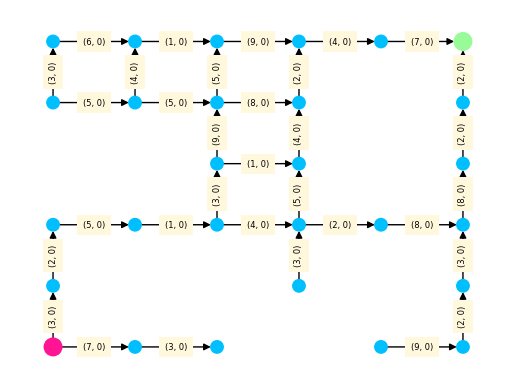

In [5]:
G=make_grid_instance(6,6,0.8)
draw_network_trafic(G)

## Residual Graph

### Computing the residual graph from a trafic network and a flow

In [6]:
# Step 1: Define the residual graph G_f
def compute_residual_graph(G):
    #flow=nx.get_edge_attributes(G,"flow")
    G_f = nx.DiGraph()
    for u, v, data in G.edges(data=True):
        capacity = data['capacity']
        flow=data['flow']
        # Add forward edge with residual capacity
        if capacity>flow:
            G_f.add_edge(u, v, capacity=capacity - flow,direction="forward")
        # Add backward edge for flow cancellation, initially 0 if not present
        if flow>0:
            G_f.add_edge(v, u, capacity=flow,direction="backward")
    ## add position atribute to nodes
    pos=nx.get_node_attributes(G,"pos")
    for v in G_f.nodes():
        G_f.nodes[v]["pos"]=pos[v]
        G_f.nodes[v]["color"]=G.nodes[v]["color"]
        G_f.nodes[v]["node_size"]=G.nodes[v]["node_size"]
    G_f.graph["start"]=G.graph["start"]
    G_f.graph["end"]=G.graph["end"]
    return G_f

## Modify positions so that arrows are a bit shorter

In [7]:
def shorten_line(u, v, offset=0.1):
    # Calculate the vector from u to v
    vector = np.array(v) - np.array(u)
    
    # Normalize the vector
    norm_vector = vector / np.linalg.norm(vector)
    
    # Calculate new points offset from the original u and v
    new_u = np.array(u) + norm_vector * offset
    new_v = np.array(v) - norm_vector * offset
    
    return new_u, new_v

## Draw residual graph

In [8]:

def draw_residual_graph(G_res,path=[],ax=None):
    # In case axis needs to be speficied
    if ax is None:
        ax = plt.gca()
    ax.axis('off')  # This turns off the bounding box and axes ticks

    # Get positions from graph
    pos=nx.get_node_attributes(G_res, 'pos')
    # Get node_size from graph
    node_size=nx.get_node_attributes(G_res,'node_size')
    node_size=[node_size[node]for node in G_res.nodes()]
    # Get node color from graph
    node_colors=nx.get_node_attributes(G_res, 'color')
    node_colors=[node_colors[node]for node in G_res.nodes()]
    # Draw nodes
    nx.draw_networkx_nodes(G_res, pos, node_color=node_colors,node_size=node_size,ax=ax)
    # Get node directions from graph
    edge_directions = nx.get_edge_attributes(G_res, 'direction')
    # ege colors
    edge_colors={edge:"black" for edge in G_res.edges()}
    for edge in path:
        edge_colors[edge]="deeppink"

    # Draw the edges
    for (u, v), color in edge_directions.items():
        if color == 'forward':
            # Draw straight blue edge
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],arrows=True,edge_color=edge_colors[(u,v)],ax=None)
        elif color == 'backward':
            # Draw curved red edge
            start_pos, end_pos = shorten_line(pos[u], pos[v], offset=0.1)
            arrow = FancyArrowPatch(start_pos,end_pos, connectionstyle='arc3,rad=0.2',
                                    arrowstyle='-|>',mutation_scale=10.0, lw=1,color=edge_colors[(u,v)])
            
            ax.add_patch(arrow)

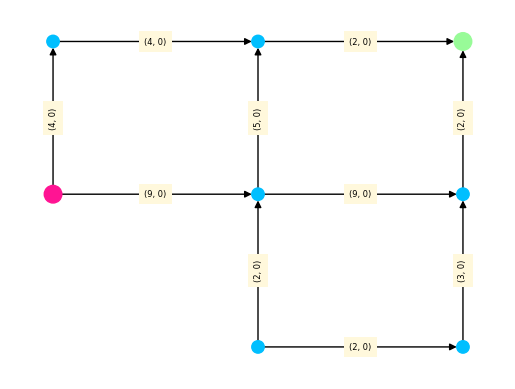

In [9]:
G=make_grid_instance(3,3,0.8)
G_r=compute_residual_graph(G)
draw_network_trafic(G)

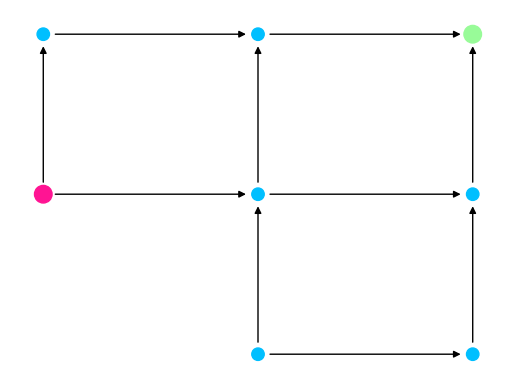

In [11]:
draw_residual_graph(G_r)

## Find Path in Residual Graph

In [13]:
def path_finder(Graph,start):
    """
    Takes a directed graph and a starting node. Returns a dictionary with keys:
    "level": a list of sets, the new nodes that can be visited on each step
    "predecesor": A dictionary that assigns the predecesor to each visited node
    "visited": The list of visited nodes 
    """
    level=[{start}]
    visited={start}
    next_level={start}
    predecesor=dict()
    predecesor[start]=None
    while next_level:
        level.append(next_level)
        visited=visited.union(next_level)
        new=set()
        for node in next_level:
            new_neighbors={vertex for vertex in Graph.successors(node) if vertex not in visited}
            visited=visited.union(new_neighbors)
            for vertex in new_neighbors:
                predecesor[vertex]=node
            new=new.union(new_neighbors)
        next_level=new
    ans=dict()
    ans["level"]=level
    ans["predecessor"]=predecesor
    ans["visited"]=visited
    return ans


In [14]:
def shortest_path(predecessors, start, end):
    """
    Reconstruct the shortest path from the predecessors.

    Parameters:
    - predecessors: a dictionary with the preceding node in the shortest path
    - start: the starting node
    - end: the ending node

    Returns:
    - path: list of nodes representing the shortest path from start to end
    """
    path = [end]
    while path[-1] != start:
        path.append(predecessors[path[-1]])
    path.reverse()
    return path

In [15]:
def bfs_path(graph,start,end):
    """
    Takes a graph,start and end nodes and returns a shortest path between start and end
    """
    search_results=path_finder(graph,start)
    predecessors= search_results["predecessor"]
    visited=search_results["visited"]
   
    if end not in visited:
        return None
    else:
        sequence= shortest_path(predecessors,start,end)
        k=len(sequence)
        return [(sequence[i],sequence[i+1]) for i in range(k-1)]

In [16]:
start=G_r.graph["start"]
end=G_r.graph["end"]
bfs_path(G_r,start,end)

[((0, 1), (1, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2))]

## Update Network Graph

In [17]:
def compute_updated_flow(G,G_res, path):
    flow=nx.get_edge_attributes(G,"flow")
    if path is None:
        return G
    # Find the minimum residual capacity of the edges along the path
    bottle_neck = min(G_res[u][v]['capacity'] for (u, v) in path)
    # Update the flow along the path
    for u, v in path:
        if (u, v) in flow:
            flow[(u, v)] += bottle_neck
        else:
            # Initialize reverse flow to 0 if it doesn't exist
            flow.setdefault((v, u), 0)
            flow[(v, u)] -= bottle_neck
        G_updated=G.copy()
        for u,v in G_updated.edges():
            G_updated[u][v]["flow"]=flow[(u,v)]

    return G_updated

## Compute the min cut associated to the final residual graph

In [21]:
def frame_min_cut(Graph,Graph_res):
    G=Graph.copy()
    G_res=Graph_res.copy()
        
    visited=path_finder(G_res,G_res.graph["start"])["visited"]
    for v in G_res.nodes():
        if v in visited:
            G_res.nodes[v]["color"]="deeppink"
        else:
            G_res.nodes[v]["color"]="palegreen"
    for v in G.nodes():
        if v in visited:
            G.nodes[v]["color"]="deeppink"
        else:
            G.nodes[v]["color"]="palegreen"
    return G,G_res

## Ford Fulkerson Frames

In [23]:
def ford_fulkerson_frames(Graph):
    # Initialize flow with 0 for all edges
    #flow = {edge: 0 for edge in G.edges()}
    
    # Create the initial residual graph
    G=Graph.copy()
    start=G.graph["start"]
    end=G.graph["end"]
    G_res = compute_residual_graph(G)
    ans=[]
    # Find a path from source to sink in residual graph
    path=bfs_path(G_res,start,end)
    # In case there is no flow
    if not path:
        ans=[(G.copy(),G_res.copy(),[])]
    while path:
        # add to frames the graph, the residual graph and an empty path
        ans.append((G.copy(),G_res.copy(),[]))
        # add to frames the graph, the residual graph and and the path
        ans.append((G.copy(),G_res.copy(),path))
        # Compute updated graph
        G=compute_updated_flow(G,G_res,path)
        # add to frames the graph, the residual graph and the path
        ans.append((G.copy(),G_res.copy(),path))
        # Compute the residual graph
        G_res=compute_residual_graph(G)
        #Compute the path in the residual graph
        path=bfs_path(G_res,start,end)
        
        # max_flow = sum(G[u][v]["flow"] for u,v in list(G.out_edges(start)))
        # print(max_flow)
    G,G_res=frame_min_cut(G,G_res)
    ans.append((G.copy(),G_res.copy(),[]))

    return ans

## Animate Ford Fulkerson

In [28]:
def animate_ford_fulkerson(G):

    # Create a figure and two subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    fig.set_facecolor('cornsilk')
    ax0 = axs[0]
    ax1 =axs[1]
    frames=ford_fulkerson_frames(G)
    def update(frame):
        # Clear the previous drawings
        axs[0].clear()
        axs[1].clear()
        draw_network_trafic(frame[0],ax=ax0)
        draw_residual_graph(frame[1],frame[2],ax=ax1)

        flow_value = sum(frame[0][u][v]["flow"] for u,v in list(frame[0].out_edges(frame[0].graph["start"])))
        # Set titles
        axs[0].set_title(f"Network flow: {flow_value}")
        axs[1].set_title('Residual Graph')
        fig.suptitle('Ford Fulkerson algorithm', fontsize=16)
        #axs.set_title("Hola")
    # Create an animation
    ani = FuncAnimation(fig, update, frames=frames, interval=1000, repeat=True)

    ani_jshtml = ani.to_jshtml()
        #print(frames)
        # Display the animation
    return(HTML(ani_jshtml))

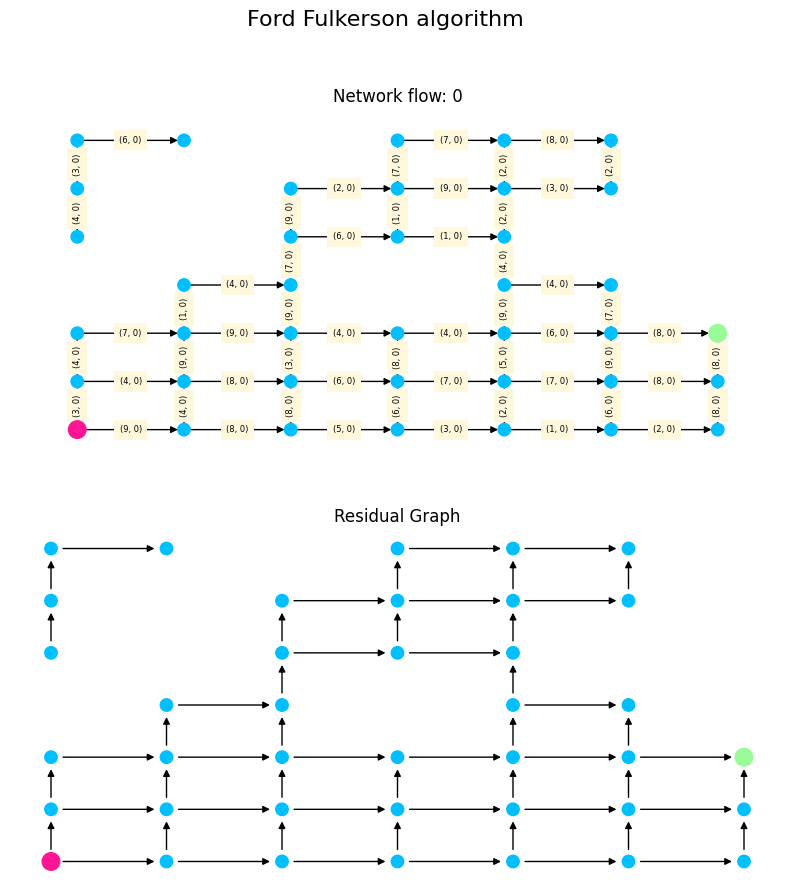

In [40]:
G=make_grid_instance(7,7,0.8)
animate_ford_fulkerson(G)